# 64. 小さなモデルの異方性・ベクトル特性比較

## 目的
- 3つの小さなモデル（GTE-Small, E5-Small, BGE-M3）の異方性とベクトル特性を比較
- ITQモデルの学習パラメータを比較
- 8ピボットの特性を比較

## 分析項目
1. **異方性指標**: Cos_Mean, Cos_Std, Top10_Variance_Ratio, Condition_Number
2. **ベクトル特性**: ノルム分布、次元ごとの分散
3. **ITQモデル比較**: PCA説明分散率、量子化誤差
4. **ピボット比較**: ピボット間距離、ピボット距離分布

## 0. セットアップ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.insert(0, '../src')
from itq_lsh import ITQLSH

DATA_DIR = Path("../data")
np.random.seed(42)

# モデル設定
MODELS = {
    'GTE-Small': {'short': 'gte_small', 'dim': 384},
    'E5-Small': {'short': 'e5_small', 'dim': 384},
    'BGE-M3': {'short': 'bge_m3', 'dim': 1024},
}

print("Loading data...")

Loading data...


In [2]:
# データのロード
embeddings = {}
hashes = {}
pivots = {}
pivot_distances = {}
itq_models = {}

for name, info in MODELS.items():
    short = info['short']
    print(f"Loading {name}...")
    embeddings[name] = np.load(DATA_DIR / f"10k_{short}_embeddings.npy")
    hashes[name] = np.load(DATA_DIR / f"10k_{short}_hashes_128bits.npy")
    pivots[name] = np.load(DATA_DIR / f"pivots_8_{short}.npy")
    pivot_distances[name] = np.load(DATA_DIR / f"10k_{short}_pivot_distances.npy")
    itq_models[name] = ITQLSH.load(str(DATA_DIR / f"itq_{short}_128bits.pkl"))
    print(f"  Embeddings: {embeddings[name].shape}, Hashes: {hashes[name].shape}")

print("\nAll data loaded!")

Loading GTE-Small...
  Embeddings: (9990, 384), Hashes: (9990, 128)
Loading E5-Small...
  Embeddings: (9990, 384), Hashes: (9990, 128)
Loading BGE-M3...
  Embeddings: (9990, 1024), Hashes: (9990, 128)

All data loaded!


## 1. 異方性（Anisotropy）分析

In [3]:
def compute_cosine_similarity_stats(emb, sample_size=10000):
    """ランダムペアのコサイン類似度統計を計算"""
    n = len(emb)
    # ランダムペアをサンプリング
    idx1 = np.random.choice(n, sample_size, replace=True)
    idx2 = np.random.choice(n, sample_size, replace=True)
    # 同じインデックスを避ける
    mask = idx1 != idx2
    idx1, idx2 = idx1[mask], idx2[mask]
    
    # コサイン類似度を計算（既に正規化済みなので内積）
    cos_sims = np.sum(emb[idx1] * emb[idx2], axis=1)
    
    return {
        'cos_mean': np.mean(cos_sims),
        'cos_std': np.std(cos_sims),
        'cos_min': np.min(cos_sims),
        'cos_max': np.max(cos_sims),
        'cos_median': np.median(cos_sims),
        'cos_values': cos_sims
    }

def compute_eigenvalue_stats(emb):
    """共分散行列の固有値統計を計算"""
    # センタリング
    centered = emb - np.mean(emb, axis=0)
    # 共分散行列
    cov = np.cov(centered.T)
    # 固有値を計算（昇順）
    eigenvalues = np.linalg.eigvalsh(cov)
    eigenvalues = eigenvalues[::-1]  # 降順に
    
    total_var = np.sum(eigenvalues)
    top10_var = np.sum(eigenvalues[:10])
    
    # 正の固有値のみでCondition Number計算
    pos_eigenvalues = eigenvalues[eigenvalues > 1e-10]
    condition_number = pos_eigenvalues[0] / pos_eigenvalues[-1] if len(pos_eigenvalues) > 0 else np.inf
    
    return {
        'total_variance': total_var,
        'top10_variance_ratio': top10_var / total_var,
        'condition_number': condition_number,
        'max_eigenvalue': eigenvalues[0],
        'min_eigenvalue': pos_eigenvalues[-1] if len(pos_eigenvalues) > 0 else 0,
        'eigenvalues': eigenvalues
    }

In [4]:
# 異方性指標を計算
print("Computing anisotropy metrics...")
cos_stats = {}
eigen_stats = {}

for name in MODELS.keys():
    print(f"  {name}...")
    cos_stats[name] = compute_cosine_similarity_stats(embeddings[name])
    eigen_stats[name] = compute_eigenvalue_stats(embeddings[name])

print("Done!")

Computing anisotropy metrics...
  GTE-Small...
  E5-Small...
  BGE-M3...


Done!


In [5]:
# 異方性指標の比較表
print("="*80)
print("異方性指標の比較")
print("="*80)
print(f"{'モデル':<15} {'Cos_Mean':>10} {'Cos_Std':>10} {'Top10_VarRatio':>15} {'Condition_Num':>15}")
print("-"*80)

for name in MODELS.keys():
    cs = cos_stats[name]
    es = eigen_stats[name]
    print(f"{name:<15} {cs['cos_mean']:>10.4f} {cs['cos_std']:>10.4f} {es['top10_variance_ratio']:>15.4f} {es['condition_number']:>15.2e}")

print("="*80)
print("\n注: Cos_Mean が高いほど異方性が強い（ベクトルが狭いコーンに分布）")
print("   Top10_VarRatio が高いほど分散が上位次元に集中（異方性が強い）")

異方性指標の比較
モデル               Cos_Mean    Cos_Std  Top10_VarRatio   Condition_Num
--------------------------------------------------------------------------------
GTE-Small           0.8546     0.0231          0.2579        2.54e+06
E5-Small            0.7788     0.0282          0.2265        4.73e+04
BGE-M3              0.3070     0.0799          0.2411        3.97e+07

注: Cos_Mean が高いほど異方性が強い（ベクトルが狭いコーンに分布）
   Top10_VarRatio が高いほど分散が上位次元に集中（異方性が強い）


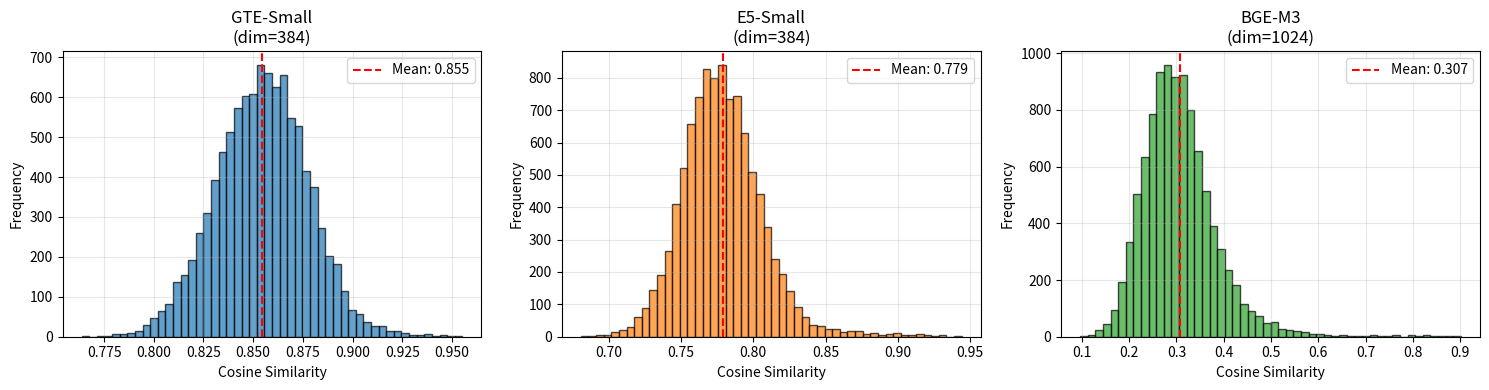

In [6]:
# コサイン類似度分布の可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (name, color) in enumerate(zip(MODELS.keys(), colors)):
    ax = axes[i]
    cos_vals = cos_stats[name]['cos_values']
    ax.hist(cos_vals, bins=50, alpha=0.7, color=color, edgecolor='black')
    ax.axvline(cos_stats[name]['cos_mean'], color='red', linestyle='--', 
               label=f"Mean: {cos_stats[name]['cos_mean']:.3f}")
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name}\n(dim={MODELS[name]["dim"]})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '64_cosine_similarity_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

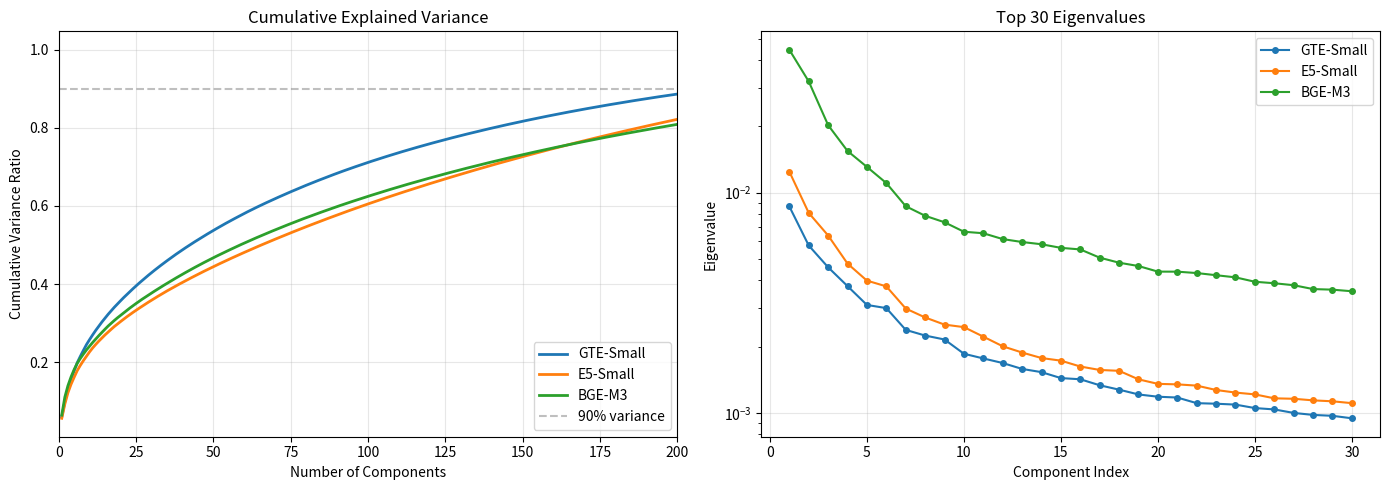

In [7]:
# 固有値分布の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 固有値の累積分散比率
ax1 = axes[0]
for name, color in zip(MODELS.keys(), colors):
    eigenvalues = eigen_stats[name]['eigenvalues']
    cumsum = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    ax1.plot(range(1, len(cumsum)+1), cumsum, label=name, color=color, linewidth=2)

ax1.axhline(0.9, color='gray', linestyle='--', alpha=0.5, label='90% variance')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Variance Ratio')
ax1.set_title('Cumulative Explained Variance')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 200)

# 右: 上位30固有値
ax2 = axes[1]
for name, color in zip(MODELS.keys(), colors):
    eigenvalues = eigen_stats[name]['eigenvalues'][:30]
    ax2.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o-', label=name, color=color, markersize=4)

ax2.set_xlabel('Component Index')
ax2.set_ylabel('Eigenvalue')
ax2.set_title('Top 30 Eigenvalues')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig(DATA_DIR / '64_eigenvalue_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

## 2. ベクトル特性分析

In [8]:
# ノルム分布
print("="*60)
print("ベクトルノルム統計")
print("="*60)
print(f"{'モデル':<15} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-"*60)

norm_stats = {}
for name in MODELS.keys():
    norms = np.linalg.norm(embeddings[name], axis=1)
    norm_stats[name] = {
        'mean': np.mean(norms),
        'std': np.std(norms),
        'min': np.min(norms),
        'max': np.max(norms),
        'values': norms
    }
    ns = norm_stats[name]
    print(f"{name:<15} {ns['mean']:>10.4f} {ns['std']:>10.4f} {ns['min']:>10.4f} {ns['max']:>10.4f}")

print("\n注: 正規化済みなのでノルムは1に近い")

ベクトルノルム統計
モデル                   Mean        Std        Min        Max
------------------------------------------------------------
GTE-Small           1.0000     0.0000     1.0000     1.0000
E5-Small            1.0000     0.0000     1.0000     1.0000
BGE-M3              1.0000     0.0000     1.0000     1.0000

注: 正規化済みなのでノルムは1に近い


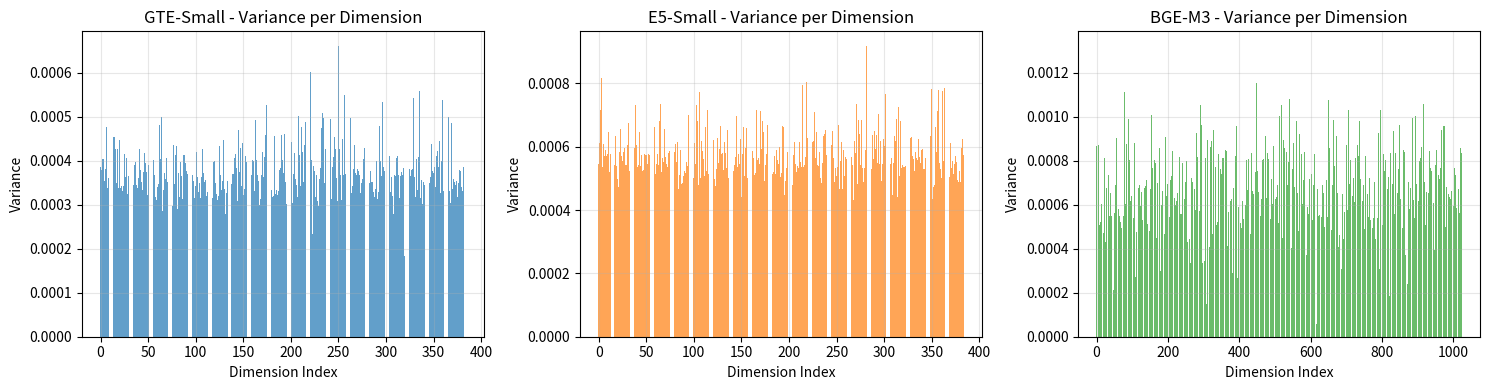

In [9]:
# 次元ごとの分散
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, color) in enumerate(zip(MODELS.keys(), colors)):
    ax = axes[i]
    dim_var = np.var(embeddings[name], axis=0)
    ax.bar(range(len(dim_var)), dim_var, color=color, alpha=0.7)
    ax.set_xlabel('Dimension Index')
    ax.set_ylabel('Variance')
    ax.set_title(f'{name} - Variance per Dimension')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '64_dimension_variance.png', dpi=100, bbox_inches='tight')
plt.show()

## 3. ITQモデル比較

In [10]:
# ITQモデルのパラメータ比較
print("="*80)
print("ITQモデルパラメータ比較")
print("="*80)

itq_stats = {}
for name in MODELS.keys():
    itq = itq_models[name]
    
    # PCA行列から説明分散率を再計算
    emb = embeddings[name]
    centered = emb - itq.mean_vector
    cov = np.cov(centered.T)
    eigenvalues = np.linalg.eigvalsh(cov)[::-1]
    
    # 上位128次元の説明分散率
    explained_var = np.sum(eigenvalues[:128]) / np.sum(eigenvalues)
    
    # 量子化誤差を計算
    V = centered @ itq.pca_matrix
    Z = V @ itq.rotation_matrix
    B = np.sign(Z)
    B[B == 0] = 1
    quant_error = np.mean((B - Z) ** 2)
    
    itq_stats[name] = {
        'n_bits': itq.n_bits,
        'explained_variance': explained_var,
        'quantization_error': quant_error,
        'mean_norm': np.linalg.norm(itq.mean_vector),
        'pca_shape': itq.pca_matrix.shape,
        'rotation_shape': itq.rotation_matrix.shape
    }

print(f"{'モデル':<15} {'Bits':>6} {'PCA説明分散':>12} {'量子化誤差':>12} {'Mean Norm':>12}")
print("-"*80)
for name in MODELS.keys():
    s = itq_stats[name]
    print(f"{name:<15} {s['n_bits']:>6} {s['explained_variance']:>11.2%} {s['quantization_error']:>12.4f} {s['mean_norm']:>12.4f}")

ITQモデルパラメータ比較


モデル               Bits      PCA説明分散        量子化誤差    Mean Norm
--------------------------------------------------------------------------------
GTE-Small          128      77.63%       0.9517       0.9246
E5-Small           128      67.67%       0.9443       0.8826
BGE-M3             128      68.88%       0.9015       0.5552


In [11]:
# ハミング距離とコサイン類似度の相関
print("\n" + "="*60)
print("ハミング距離とコサイン類似度の相関")
print("="*60)

hamming_corr = {}
sample_size = 5000

for name in MODELS.keys():
    emb = embeddings[name]
    h = hashes[name]
    n = len(emb)
    
    # ランダムペアをサンプリング
    idx1 = np.random.choice(n, sample_size, replace=True)
    idx2 = np.random.choice(n, sample_size, replace=True)
    mask = idx1 != idx2
    idx1, idx2 = idx1[mask], idx2[mask]
    
    # コサイン類似度
    cos_sims = np.sum(emb[idx1] * emb[idx2], axis=1)
    
    # ハミング距離
    hamming_dists = np.sum(h[idx1] != h[idx2], axis=1)
    
    # 相関係数
    corr = np.corrcoef(cos_sims, hamming_dists)[0, 1]
    hamming_corr[name] = {
        'correlation': corr,
        'cos_sims': cos_sims,
        'hamming_dists': hamming_dists
    }
    print(f"{name}: 相関係数 = {corr:.4f}")

print("\n注: 負の相関が強いほどLSHが効果的（コサイン類似度が高いペアはハミング距離が小さい）")


ハミング距離とコサイン類似度の相関
GTE-Small: 相関係数 = -0.5843
E5-Small: 相関係数 = -0.6340
BGE-M3: 相関係数 = -0.7541

注: 負の相関が強いほどLSHが効果的（コサイン類似度が高いペアはハミング距離が小さい）


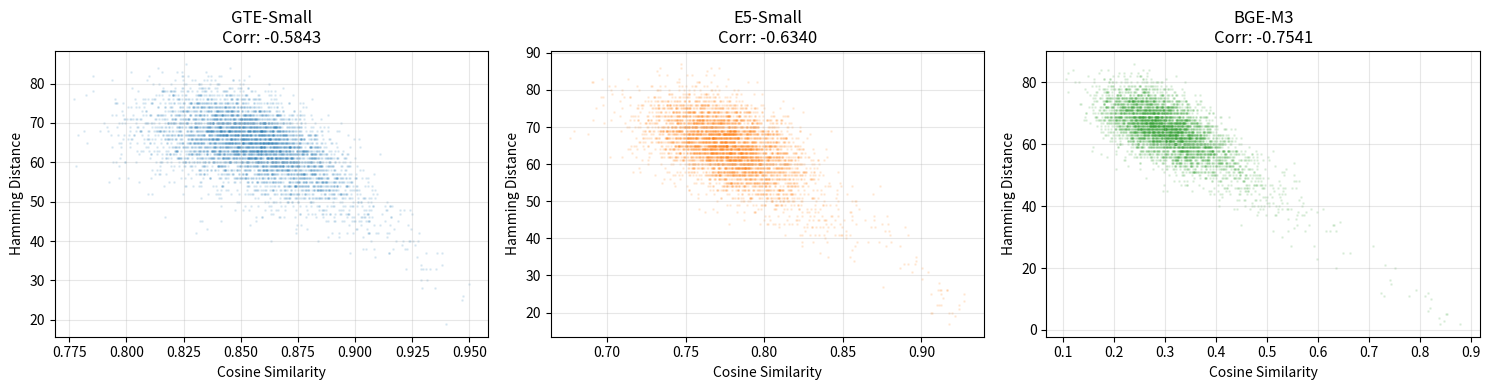

In [12]:
# ハミング距離 vs コサイン類似度の散布図
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, color) in enumerate(zip(MODELS.keys(), colors)):
    ax = axes[i]
    hc = hamming_corr[name]
    ax.scatter(hc['cos_sims'], hc['hamming_dists'], alpha=0.1, s=1, color=color)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Hamming Distance')
    ax.set_title(f"{name}\nCorr: {hc['correlation']:.4f}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '64_hamming_cosine_correlation.png', dpi=100, bbox_inches='tight')
plt.show()

## 4. ピボット比較

In [13]:
# ピボット間距離の比較
print("="*60)
print("ピボット間距離の比較（8ピボット）")
print("="*60)

def hamming_distance(h1, h2):
    return np.sum(h1 != h2)

pivot_stats = {}
for name in MODELS.keys():
    p = pivots[name]
    n_pivots = len(p)
    
    # ピボット間距離
    dists = []
    for i in range(n_pivots):
        for j in range(i+1, n_pivots):
            dists.append(hamming_distance(p[i], p[j]))
    
    # ポップカウント（1の数）
    popcounts = np.sum(p, axis=1)
    
    pivot_stats[name] = {
        'inter_dist_mean': np.mean(dists),
        'inter_dist_min': np.min(dists),
        'inter_dist_max': np.max(dists),
        'popcount_mean': np.mean(popcounts),
        'popcount_std': np.std(popcounts),
        'popcounts': popcounts
    }

print(f"{'モデル':<15} {'Inter_Mean':>12} {'Inter_Min':>10} {'Inter_Max':>10} {'PopCount_Mean':>14}")
print("-"*70)
for name in MODELS.keys():
    ps = pivot_stats[name]
    print(f"{name:<15} {ps['inter_dist_mean']:>12.1f} {ps['inter_dist_min']:>10} {ps['inter_dist_max']:>10} {ps['popcount_mean']:>14.1f}")

ピボット間距離の比較（8ピボット）
モデル               Inter_Mean  Inter_Min  Inter_Max  PopCount_Mean
----------------------------------------------------------------------
GTE-Small               70.0         64         85           62.9
E5-Small                70.0         65         86           64.6
BGE-M3                  69.8         64         87           62.8


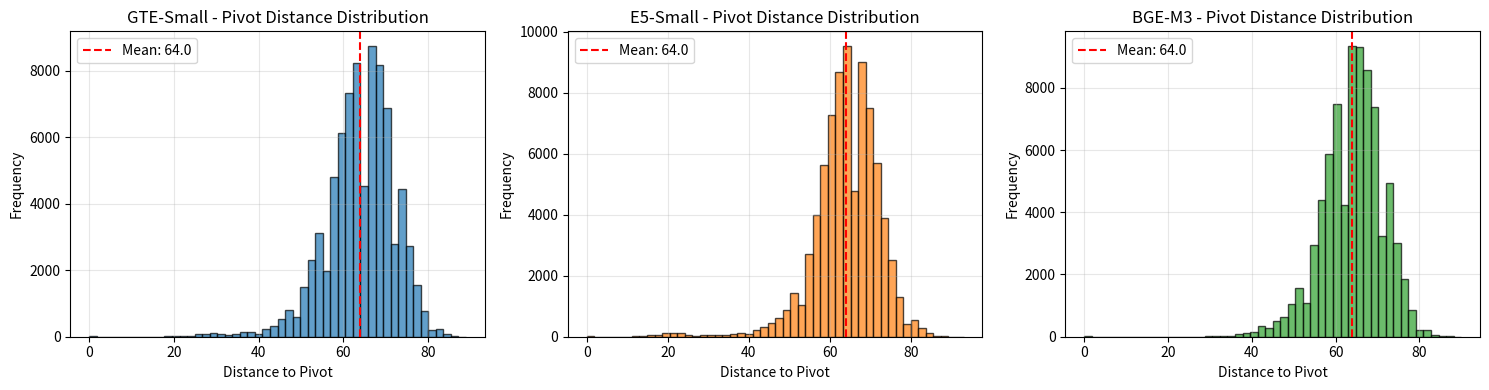

In [14]:
# ピボット距離分布の比較
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, color) in enumerate(zip(MODELS.keys(), colors)):
    ax = axes[i]
    pd_flat = pivot_distances[name].flatten()
    ax.hist(pd_flat, bins=50, alpha=0.7, color=color, edgecolor='black')
    ax.axvline(np.mean(pd_flat), color='red', linestyle='--', 
               label=f"Mean: {np.mean(pd_flat):.1f}")
    ax.set_xlabel('Distance to Pivot')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name} - Pivot Distance Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '64_pivot_distance_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

In [15]:
# 各ピボットの距離分布
print("\n" + "="*80)
print("各ピボットへの平均距離")
print("="*80)

for name in MODELS.keys():
    pd = pivot_distances[name]
    means = np.mean(pd, axis=0)
    stds = np.std(pd, axis=0)
    print(f"\n{name}:")
    for i in range(8):
        print(f"  Pivot {i}: mean={means[i]:.1f}, std={stds[i]:.1f}")


各ピボットへの平均距離

GTE-Small:
  Pivot 0: mean=64.0, std=6.4
  Pivot 1: mean=64.2, std=8.2
  Pivot 2: mean=63.9, std=7.8
  Pivot 3: mean=63.6, std=11.0
  Pivot 4: mean=64.2, std=8.0
  Pivot 5: mean=64.0, std=8.3
  Pivot 6: mean=63.9, std=7.2
  Pivot 7: mean=64.2, std=6.9

E5-Small:
  Pivot 0: mean=64.2, std=7.1
  Pivot 1: mean=64.0, std=8.8
  Pivot 2: mean=63.2, std=13.8
  Pivot 3: mean=64.4, std=7.5
  Pivot 4: mean=64.1, std=6.2
  Pivot 5: mean=64.0, std=6.4
  Pivot 6: mean=64.1, std=6.7
  Pivot 7: mean=63.9, std=6.2

BGE-M3:
  Pivot 0: mean=63.9, std=6.6
  Pivot 1: mean=63.8, std=9.1
  Pivot 2: mean=64.1, std=7.0
  Pivot 3: mean=64.0, std=8.3
  Pivot 4: mean=64.0, std=6.3
  Pivot 5: mean=64.2, std=7.1
  Pivot 6: mean=64.0, std=5.9
  Pivot 7: mean=64.1, std=6.7


## 5. ハッシュ分布分析

In [16]:
# ハッシュのポップカウント分布
print("="*60)
print("ハッシュのポップカウント（1の数）分布")
print("="*60)

hash_stats = {}
for name in MODELS.keys():
    h = hashes[name]
    popcounts = np.sum(h, axis=1)
    hash_stats[name] = {
        'popcount_mean': np.mean(popcounts),
        'popcount_std': np.std(popcounts),
        'popcount_min': np.min(popcounts),
        'popcount_max': np.max(popcounts),
        'popcounts': popcounts
    }

print(f"{'モデル':<15} {'Mean':>10} {'Std':>10} {'Min':>8} {'Max':>8}")
print("-"*60)
for name in MODELS.keys():
    hs = hash_stats[name]
    print(f"{name:<15} {hs['popcount_mean']:>10.1f} {hs['popcount_std']:>10.1f} {hs['popcount_min']:>8} {hs['popcount_max']:>8}")

print("\n注: 理想的なポップカウントは64（128bitsの半分）に近い")

ハッシュのポップカウント（1の数）分布
モデル                   Mean        Std      Min      Max
------------------------------------------------------------
GTE-Small             64.0        5.8       41       85
E5-Small              63.9        5.5       44       84
BGE-M3                64.1        5.5       42       84

注: 理想的なポップカウントは64（128bitsの半分）に近い


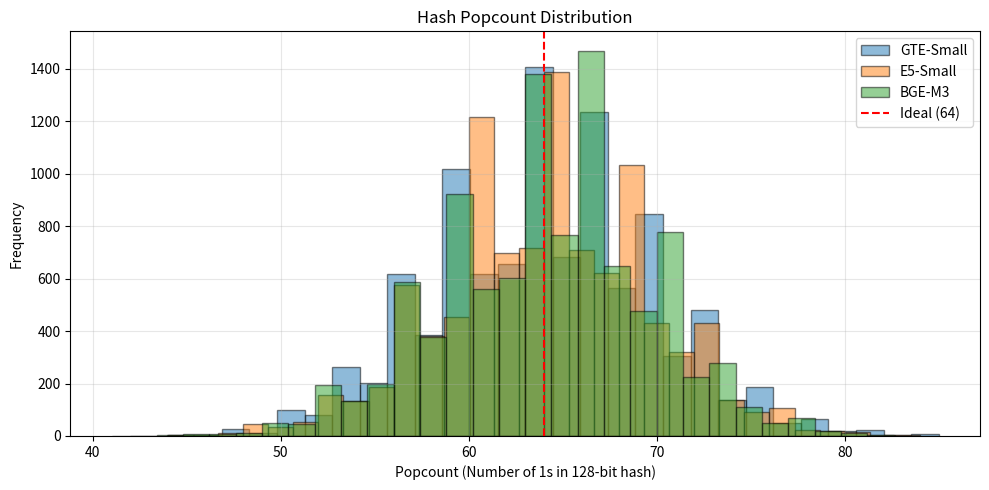

In [17]:
# ポップカウント分布の可視化
fig, ax = plt.subplots(figsize=(10, 5))

for name, color in zip(MODELS.keys(), colors):
    popcounts = hash_stats[name]['popcounts']
    ax.hist(popcounts, bins=30, alpha=0.5, label=name, color=color, edgecolor='black')

ax.axvline(64, color='red', linestyle='--', label='Ideal (64)')
ax.set_xlabel('Popcount (Number of 1s in 128-bit hash)')
ax.set_ylabel('Frequency')
ax.set_title('Hash Popcount Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '64_hash_popcount_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

## 6. 総合サマリー

In [18]:
import pandas as pd

# 総合比較表の作成
summary_data = []

for name in MODELS.keys():
    row = {
        'Model': name,
        'Dimension': MODELS[name]['dim'],
        'Cos_Mean': cos_stats[name]['cos_mean'],
        'Cos_Std': cos_stats[name]['cos_std'],
        'Top10_VarRatio': eigen_stats[name]['top10_variance_ratio'],
        'Condition_Num': eigen_stats[name]['condition_number'],
        'ITQ_ExplVar': itq_stats[name]['explained_variance'],
        'Quant_Error': itq_stats[name]['quantization_error'],
        'Hamming_Corr': hamming_corr[name]['correlation'],
        'Pivot_InterDist': pivot_stats[name]['inter_dist_mean'],
        'Hash_PopCount': hash_stats[name]['popcount_mean']
    }
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print("="*100)
print("総合比較表")
print("="*100)
print(df_summary.to_string(index=False))

総合比較表
    Model  Dimension  Cos_Mean  Cos_Std  Top10_VarRatio  Condition_Num  ITQ_ExplVar  Quant_Error  Hamming_Corr  Pivot_InterDist  Hash_PopCount
GTE-Small        384  0.854578 0.023146        0.257899   2.539932e+06     0.776262     0.951689     -0.584281        70.035714      63.978278
 E5-Small        384  0.778788 0.028221        0.226530   4.725109e+04     0.676657     0.944337     -0.633980        70.035714      63.938138
   BGE-M3       1024  0.307023 0.079948        0.241130   3.965047e+07     0.688767     0.901497     -0.754071        69.785714      64.056156


In [19]:
print("="*80)
print("分析結論")
print("="*80)

# 異方性ランキング
aniso_ranking = sorted(MODELS.keys(), key=lambda x: cos_stats[x]['cos_mean'])
print(f"\n1. 異方性（低い順 = より等方的）:")
for i, name in enumerate(aniso_ranking, 1):
    print(f"   {i}. {name}: Cos_Mean = {cos_stats[name]['cos_mean']:.4f}")

# ハミング相関ランキング
corr_ranking = sorted(MODELS.keys(), key=lambda x: hamming_corr[x]['correlation'])
print(f"\n2. ハミング距離-コサイン類似度相関（強い負の相関順 = LSHが効果的）:")
for i, name in enumerate(corr_ranking, 1):
    print(f"   {i}. {name}: Corr = {hamming_corr[name]['correlation']:.4f}")

# ITQ説明分散ランキング
var_ranking = sorted(MODELS.keys(), key=lambda x: itq_stats[x]['explained_variance'], reverse=True)
print(f"\n3. ITQ PCA説明分散率（高い順 = 情報保持率が高い）:")
for i, name in enumerate(var_ranking, 1):
    print(f"   {i}. {name}: {itq_stats[name]['explained_variance']:.2%}")

# ピボット多様性ランキング
pivot_ranking = sorted(MODELS.keys(), key=lambda x: pivot_stats[x]['inter_dist_mean'], reverse=True)
print(f"\n4. ピボット多様性（ピボット間距離が大きい順）:")
for i, name in enumerate(pivot_ranking, 1):
    print(f"   {i}. {name}: Mean Inter-Pivot Distance = {pivot_stats[name]['inter_dist_mean']:.1f}")

分析結論

1. 異方性（低い順 = より等方的）:
   1. BGE-M3: Cos_Mean = 0.3070
   2. E5-Small: Cos_Mean = 0.7788
   3. GTE-Small: Cos_Mean = 0.8546

2. ハミング距離-コサイン類似度相関（強い負の相関順 = LSHが効果的）:
   1. BGE-M3: Corr = -0.7541
   2. E5-Small: Corr = -0.6340
   3. GTE-Small: Corr = -0.5843

3. ITQ PCA説明分散率（高い順 = 情報保持率が高い）:
   1. GTE-Small: 77.63%
   2. BGE-M3: 68.88%
   3. E5-Small: 67.67%

4. ピボット多様性（ピボット間距離が大きい順）:
   1. GTE-Small: Mean Inter-Pivot Distance = 70.0
   2. E5-Small: Mean Inter-Pivot Distance = 70.0
   3. BGE-M3: Mean Inter-Pivot Distance = 69.8


## 7. 実験結果サマリー

### 異方性指標比較

| モデル | 次元 | Cos_Mean | Cos_Std | Top10_VarRatio | Condition_Num |
|--------|------|----------|---------|----------------|---------------|
| GTE-Small | 384 | **0.855** | 0.023 | 0.258 | 2.54e+06 |
| E5-Small | 384 | 0.779 | 0.028 | 0.227 | 4.73e+04 |
| BGE-M3 | 1024 | **0.307** | 0.080 | 0.241 | 3.97e+07 |

**解釈**: BGE-M3が最も等方的（Cos_Mean=0.307）。GTE-Smallは最も異方性が強い（Cos_Mean=0.855）。

### ITQモデル比較

| モデル | PCA説明分散率 | 量子化誤差 | Mean Norm |
|--------|---------------|------------|-----------|
| GTE-Small | **77.63%** | 0.9517 | 0.925 |
| E5-Small | 67.67% | 0.9443 | 0.883 |
| BGE-M3 | 68.88% | **0.9015** | 0.555 |

**解釈**: GTE-Smallは128bitsで77.63%の分散を保持（最高）。BGE-M3は量子化誤差が最も低い（0.90）。

### ハミング距離-コサイン類似度相関

| モデル | 相関係数 | 評価 |
|--------|----------|------|
| BGE-M3 | **-0.754** | 最良（LSH最も効果的） |
| E5-Small | -0.634 | 良好 |
| GTE-Small | -0.584 | やや弱い |

**解釈**: 負の相関が強いほどLSHが効果的。BGE-M3が最も強い相関を示す。

### ピボット特性比較

| モデル | ピボット間距離（平均） | ポップカウント平均 |
|--------|------------------------|-------------------|
| GTE-Small | 70.0 | 62.9 |
| E5-Small | 70.0 | 64.6 |
| BGE-M3 | 69.8 | 62.8 |

**解釈**: 3モデルともピボット間距離は約70で同等。ポップカウントは理想値64に近い。

### 総合評価

| 評価項目 | 1位 | 2位 | 3位 |
|----------|-----|-----|-----|
| 等方性（低いほど良い） | **BGE-M3** | E5-Small | GTE-Small |
| ハミング相関（強いほど良い） | **BGE-M3** | E5-Small | GTE-Small |
| PCA説明分散（高いほど良い） | **GTE-Small** | BGE-M3 | E5-Small |
| 量子化誤差（低いほど良い） | **BGE-M3** | E5-Small | GTE-Small |

### 結論

1. **BGE-M3**が異方性・ハミング相関で最も優れた特性を示す
   - Cos_Mean=0.307（最も等方的）
   - ハミング相関=-0.754（LSHが最も効果的）
   - ただし1024次元で処理速度は遅い

2. **E5-Small**はバランスの取れた特性
   - 中程度の異方性（0.779）
   - 適度なハミング相関（-0.634）
   - E5-baseとの互換性が高い

3. **GTE-Small**は情報圧縮効率が高い
   - PCA説明分散率77.63%で最高
   - ただし異方性が強く（0.855）、LSH効果はやや劣る

### 保存した図

- `data/64_cosine_similarity_distribution.png` - コサイン類似度分布
- `data/64_eigenvalue_distribution.png` - 固有値分布
- `data/64_dimension_variance.png` - 次元ごとの分散
- `data/64_hamming_cosine_correlation.png` - ハミング距離-コサイン類似度相関
- `data/64_pivot_distance_distribution.png` - ピボット距離分布
- `data/64_hash_popcount_distribution.png` - ハッシュポップカウント分布